**5243 Project 3 Team 3**

Our project focuses on enhancing prediction accuracy while also be aware of the tradeoff of running costs in improving image classification through Convolutional Neural Network model.

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import models, layers, losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import Loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from contextlib import contextmanager
import sys, os
from io import StringIO
import time

#### Download

In [ ]:
!unzip data.zip

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`.

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset.

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


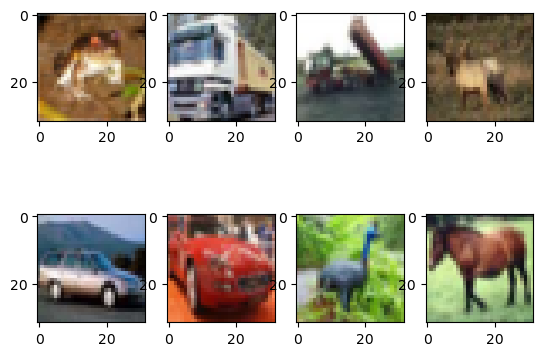

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

Given our client's priorities, we choose CNNs due to its effectiveness in image recognition with relatively lower computational demands compared to other deep learning models.

We began with normalizing images from our dataset and splited into training and validation sets, ensuring that we had a robust foundation for training our models and evaluating their performance accurately.

In [8]:
noisy_labels_one_hot = to_categorical(noisy_labels, num_classes=10)

imgs_normalized = imgs / 255.0

In [9]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(imgs_normalized, noisy_labels_one_hot, test_size=0.2, random_state=42)

# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,       # randomly rotate images to some degree
    width_shift_range=0.2,   # randomly shift images horizontally 
    height_shift_range=0.2,  # randomly shift images vertically
    horizontal_flip=True,    # randomly flip images horizontally
    zoom_range=0.2,          # randomly zoom image
)

datagen.fit(X_train)

In [7]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()

/Users/helena/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [10]:
# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(noisy_labels),
    y=noisy_labels.flatten()
)
class_weights_dict = dict(enumerate(class_weights))

In [11]:
# Fit the model
history_cnn = cnn_model.fit(X_train, y_train, 
                            batch_size=64,
                            epochs=10,
                            validation_data=(X_val, y_val),
                            class_weight=class_weights_dict
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1186 - loss: 2.2948 - val_accuracy: 0.1667 - val_loss: 2.2641
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.1752 - loss: 2.2512 - val_accuracy: 0.1933 - val_loss: 2.2371
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.2035 - loss: 2.2264 - val_accuracy: 0.2044 - val_loss: 2.2348
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.2218 - loss: 2.2051 - val_accuracy: 0.2179 - val_loss: 2.2184
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.2309 - loss: 2.1908 - val_accuracy: 0.2227 - val_loss: 2.2174
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2453 - loss: 2.1709 - val_accuracy: 0.2276 - val_loss: 2.2171
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.2517 - loss: 2.1525 - val_accuracy: 0.2343 - val_loss: 2.2186
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.2650 - loss: 2.1265 - 

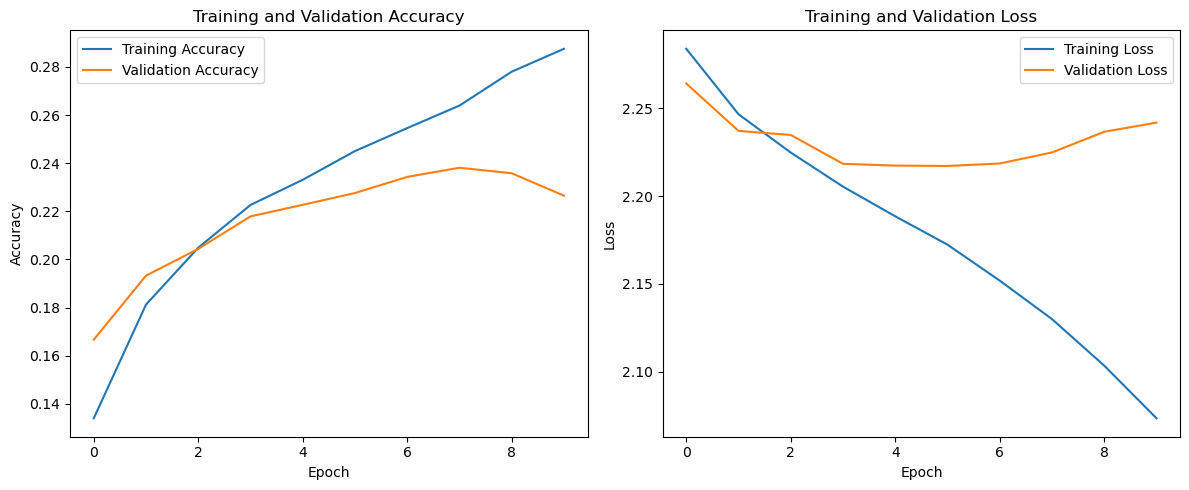

In [21]:
# Accuracy and Loss graph for Model I
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = image / 255.0
    image = np.expand_dims(image, axis=0)  # Expanding the dimensions to fit the model input
    predictions = cnn_model.predict(image)
    return np.argmax(predictions)  # Return the index of the highest probability class

### 2.3. Model II

We further enhanced our CNN model by integrating weakly supervised learning features. Specifically, we adopted a noise-robust loss function, aiming to mitigate the impact of label noise on model training. By being less sensitive to noise, this model could self-correct during training in some extent, and it woudl be more likely to generalize well from the "clean" portion of the data.
We also retrain the model with high-confidence predictions. These features and techniques addresses the challenge of label noise in our dataset as well as improve accuracy without substantially increasing model complexity.

In [13]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# use Noise-Robust Loss function to cnn model
class SymmetricCrossEntropy(Loss):
    def __init__(self, alpha=1.0, beta=2.0, from_logits=False):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        rce = tf.keras.losses.categorical_crossentropy(y_pred, y_true, from_logits=self.from_logits)
        return self.alpha * ce + self.beta * rce

def new_cnn_model_with():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(48, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(48, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(48, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=SymmetricCrossEntropy(alpha=1.0, beta=2.0), # apply loss
                  metrics=['accuracy'])
    return model

new_cnn_model = new_cnn_model_with()

/Users/helena/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
clean_images = imgs[:n_clean_noisy]
clean_images_normalized = clean_images / 255.0 # normalize the clean images

# convert cleaned label to one hot encoding
clean_labels_one_hot = to_categorical(clean_labels, num_classes=10)

In [15]:
# split dataset
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(clean_images_normalized, clean_labels_one_hot, 
                                                          test_size=0.2, random_state=42)

# initial phase
initial_history = new_cnn_model.fit(X_train_2, y_train_2, 
                                    batch_size=64,
                                    epochs=10,
                                    validation_data=(X_val_2, y_val_2))

# predictions for the entire dataset
predictions = new_cnn_model.predict(imgs_normalized)

# select high-confidence predictions
confidence_threshold = 0.9
high_confidence_indices = np.max(predictions, axis=1) > confidence_threshold
high_confidence_images = imgs_normalized[high_confidence_indices]
high_confidence_labels = predictions[high_confidence_indices]

# convert high-confidence predictions to one-hot labels for training
high_confidence_labels_one_hot = np.zeros_like(high_confidence_labels)
high_confidence_labels_one_hot[np.arange(len(high_confidence_labels)), high_confidence_labels.argmax(1)] = 1

# combine the original clean training data and the pseudo-labeled data
combined_images = np.concatenate((X_train_2, high_confidence_images), axis=0)
combined_labels = np.concatenate((y_train_2, high_confidence_labels_one_hot), axis=0)

# shuffle the combined dataset to ensure mixed data distribution
combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)

# split combined dataset
X_combined_train, X_combined_val, y_combined_train, y_combined_val = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42
)

# retrain the model on the combined dataset
history_retrain = new_cnn_model.fit(X_combined_train, y_combined_train, 
                                batch_size=64,
                                epochs=20,
                                validation_data=(X_combined_val, y_combined_val))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2077 - loss: 29.3150 - val_accuracy: 0.1845 - val_loss: 30.6777
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3863 - loss: 23.6705 - val_accuracy: 0.2150 - val_loss: 28.9086
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4329 - loss: 21.8691 - val_accuracy: 0.1755 - val_loss: 29.8793
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4914 - loss: 19.7627 - val_accuracy: 0.3650 - val_loss: 24.2636
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5210 - loss: 18.7328 - val_accuracy: 0.5045 - val_loss: 19.0837
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5373 - loss: 17.9281 - val_accuracy: 0.5105 - val_loss: 18.6805
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5576 - loss: 17.1134 - val_accuracy: 0.5040 - val_loss: 18.6454
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5948 - loss: 16.

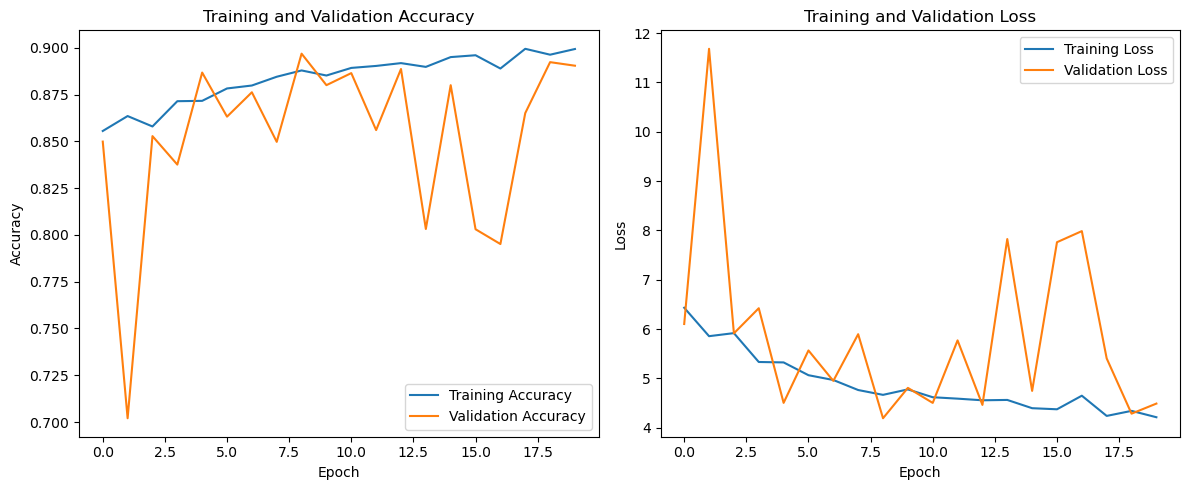

In [23]:
# Accuracy and Loss graph for Model II
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_retrain.history['accuracy'], label='Training Accuracy')
plt.plot(history_retrain.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_retrain.history['loss'], label='Training Loss')
plt.plot(history_retrain.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model II showed significant enhancements in training and validation accuracy over epochs.

In [16]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    predictions = new_cnn_model.predict(image)
    return np.argmax(predictions)

In [27]:
# Output models
cnn_model.save('output/model_I.h5')
new_cnn_model.save('output/model_II.h5')

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose.

In [17]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [18]:
# only show accuracy result, hide evaluation steps
@contextmanager
def selective_print_stdout(keep_last_lines=17):
    class Capturing(list):
        def __enter__(self):
            self._stdout = sys.stdout
            sys.stdout = self._stringio = StringIO()
            return self

        def __exit__(self, *args):
            self.extend(self._stringio.getvalue().splitlines())
            del self._stringio
            sys.stdout = self._stdout

    with Capturing() as output:
        yield

    for line in output[-keep_last_lines:]:
        print(line)

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [19]:
# Create test set
test_imgs = imgs[0:10000]
test_labels = clean_labels[:10000]

In [20]:
# Evaluation of baseline model
start_time = time.time()
evaluation(baseline_model, test_labels, test_imgs)
end_time = time.time()

base_time = end_time - start_time
print("Baseline model evaluation time: {} seconds".format(base_time))

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000

Baseline model evaluation time: 1.95173978805542 seconds


The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [22]:
# Evaluation for Model I
start_time = time.time()

with selective_print_stdout():
    evaluation(model_I, test_labels, test_imgs)

end_time = time.time()

model1_time = end_time - start_time

with selective_print_stdout():
    print("Model I evaluation time: {:.2f} seconds".format(model1_time))

              precision    recall  f1-score   support

           0       0.49      0.63      0.55      1005
           1       0.76      0.53      0.63       974
           2       0.43      0.41      0.42      1032
           3       0.45      0.27      0.33      1016
           4       0.43      0.57      0.49       999
           5       0.50      0.36      0.42       937
           6       0.53      0.64      0.58      1030
           7       0.59      0.56      0.57      1001
           8       0.60      0.70      0.65      1025
           9       0.57      0.59      0.58       981

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000

Model I evaluation time: 183.01 seconds


The overall accuracy is 0.53 for CNN model.

In [24]:
# Evaluation for Model II
start_time = time.time()

with selective_print_stdout():
    evaluation(model_II, test_labels, test_imgs)

end_time = time.time()

model2_time = end_time - start_time

with selective_print_stdout():
    print("Model II evaluation time: {:.2f} seconds".format(model2_time))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1005
           1       0.76      0.80      0.78       974
           2       0.57      0.59      0.58      1032
           3       0.64      0.42      0.51      1016
           4       0.67      0.60      0.63       999
           5       0.60      0.59      0.60       937
           6       0.64      0.83      0.72      1030
           7       0.76      0.73      0.74      1001
           8       0.69      0.84      0.76      1025
           9       0.86      0.67      0.75       981

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000

Model II evaluation time: 183.72 seconds


The overall accuracy is 0.68 after adding weakly supervised learning feature to the CNN model, which indicates a significant improve compare to the baseline model.

**Trade-off:** We noticed that these improvements did come with a tradeoff in terms of running costs. Evaluating Model I and Model II took much longer time than the baseline model due to their complexity. But in long-term consideration, improved accuracy might lead to better user satisfaction, reduced error rates, and lower manual intervention costs, which compensating for the higher running cost.

In [28]:
# Output label predicted by three models
index = list(range(len(test_labels)))
baseline = []
for image in test_imgs:
    baseline.append(baseline_model(image))
modelI = np.argmax(cnn_model.predict(test_imgs,verbose=0),1)
modelII = np.argmax(new_cnn_model.predict(test_imgs,verbose=0),1)

label_prediction = pd.DataFrame(zip(index, baseline, modelI ,modelII),
                                columns = ['Index','Baseline','Model I','Model II'])
label_prediction.to_csv('label_prediction.csv', index=False)